<a href="https://colab.research.google.com/github/buttersaltpepper/Data-analysis/blob/main/PredictingVolatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Analysis on Market Volatility**
* I wanted to analyse the saying "Sell in May and Go Away" to see what happens to volatility durign May. Surprisingly, I found volatility increased in March and April as well. May and June were also high volatility periods which reflects the uncertainty in June company earnings results.


* I also used yfinance to pull prices I believe could be predictors of volatility and modelled a simple OLS. I then did basic statistical feature selection, picking features with high effect size and significant p-value. 

* The r-squared was very high but the features did show signs of non-normality and heteroscedascity. OLS requires data to be non-linear.


* The volatility predictions on testing data are plotted and I will continue to improve this model after I have studied more on the maths behind Linear Regression Models.




In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,8)

import statsmodels.api as sm
from scipy import stats

from datetime import datetime, timedelta
import calendar

import yfinance as yf

In [ ]:
tickers_list = ['SPY', 
                'MDY', # MIDCAP
                'EEM', # EMERGY MARKETS
                'EFA', # EAFE
                'IJR', # SMALL CAP
                'VGLT', # LONG-TERM TREASURY 
                'VLUE', # VALUE
                'DVY', # DIVIDEND
                'JPY=X', # USD/JPY
                'BTC-USD', # BTC/USD
                'CL=F', # OIL
                'HO=F', # GAS
                'CL=F', # CORN
                'ZO=F', # OAT
                'ZR=F', # ROUGH RICE
                'ZS=F', # SOYBEAN
                'HE=F', # LEAN HOGS
                'LE=F', # LIVE CATTLE
                'SB=F', # SUGAR
                'GC=F', # GOLD
                'ZN=F', # 10Y T-NOTE FUTURES
                'ZF=F', # 5Y T-NOTE FUTURES
                'ZT=F', # 2Y T-NOTE FUTURES
                'PL=F', # PLATINUM
                'HG=F', # COPPER
                'PA=F', # PALLADIUM
 
]

# **EDA**

In [ ]:
data = yf.download(tickers_list)['Adj Close'].dropna()

[*********************100%***********************]  25 of 25 completed


In [ ]:
# Shift foward
fwrd = 5
rolling_feature = 30

log_rets = np.log(data/data.shift(1))

df = log_rets.rolling(rolling_feature).std()

# df['SPY_vol'] = df.SPY
df['SPY_fwd_vol'] = df.SPY.shift(-fwrd)
df.drop('SPY', axis=1, inplace=True)
df.dropna(inplace=True)
df.head()

,BTC-USD,CL=F,DVY,EEM,EFA,GC=F,HE=F,HG=F,HO=F,IJR,...,SB=F,VGLT,VLUE,ZF=F,ZN=F,ZO=F,ZR=F,ZS=F,ZT=F,SPY_fwd_vol
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-29,0.042859,0.014866,0.008435,0.012009,0.010782,0.007026,0.034209,0.010410,0.010741,0.012349,...,0.018919,0.006523,0.010134,0.002225,0.003196,0.014250,0.007530,0.017191,0.000798,0.010592
2014-10-30,0.041642,0.014841,0.008706,0.012166,0.010766,0.007954,0.034152,0.010279,0.010660,0.012387,...,0.018816,0.006524,0.010213,0.002207,0.003148,0.015482,0.007928,0.017419,0.000798,0.010124
2014-10-31,0.039865,0.014841,0.008781,0.012152,0.011364,0.008814,0.033663,0.010296,0.010649,0.012427,...,0.018583,0.006336,0.010404,0.002223,0.003183,0.015293,0.007992,0.017480,0.000800,0.010043
2014-11-03,0.039907,0.015158,0.008662,0.011934,0.011434,0.008802,0.033609,0.009888,0.010622,0.012234,...,0.017396,0.006340,0.010385,0.002214,0.003172,0.016380,0.007834,0.017367,0.000797,0.010038
2014-11-04,0.036513,0.015376,0.008505,0.011903,0.011385,0.008756,0.033542,0.010283,0.011042,0.012083,...,0.017770,0.006294,0.010370,0.002206,0.003161,0.016453,0.007850,0.017783,0.000795,0.010013


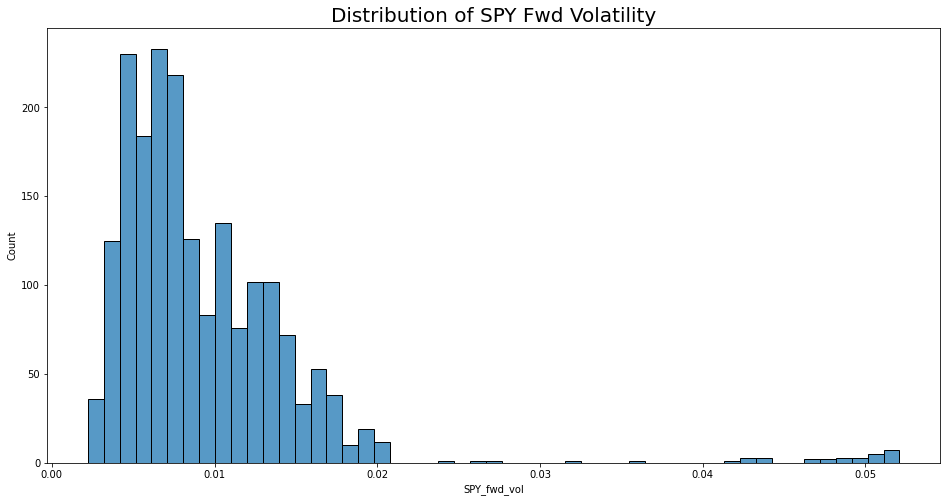

In [ ]:
plt.title('Distribution of SPY Fwd Volatility', fontsize=20)
sns.histplot(df.SPY_fwd_vol);

## **"Sell in May and Go Away" - ANOVA test**
* This is where i visualise and statistically analyse the impact of earnings seasons on market volatility

In [ ]:
def weekinmonth(dates):
    firstday_in_month = dates - pd.to_timedelta(dates.day - 1, unit='d')
    return (dates.day-1 + firstday_in_month.weekday) // 7 + 1
    
df['mnth'] = df.index.month
df['wom'] = weekinmonth(df.index)

In [ ]:
# COVID outlier
post_covid = df[(df.index > '2020-4-1')]
# pre_covid = df[(df.index < '2020-02-1')]

train = post_covid
# train = pd.concat([pre_covid, post_covid])

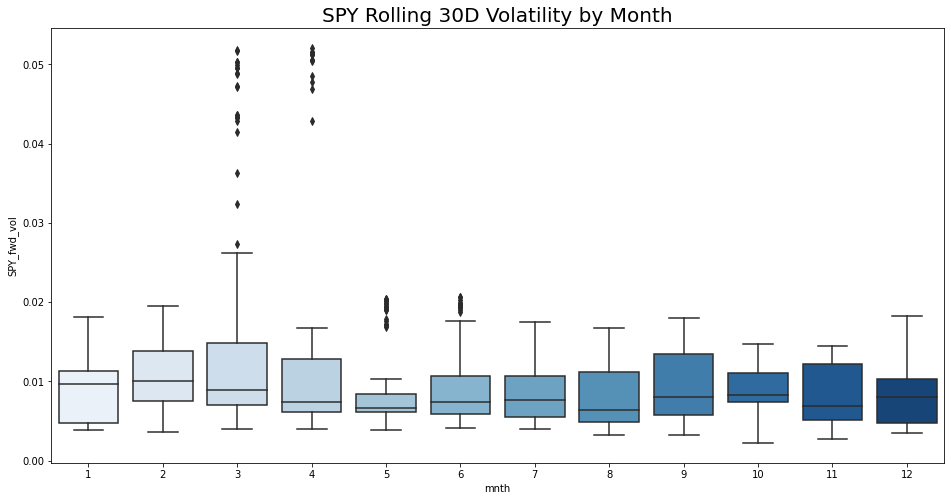

In [ ]:
plt.title('SPY Rolling 30D Volatility by Month', fontsize=20)
sns.boxplot(data=df, x='mnth', y='SPY_fwd_vol', palette='Blues')
plt.show()

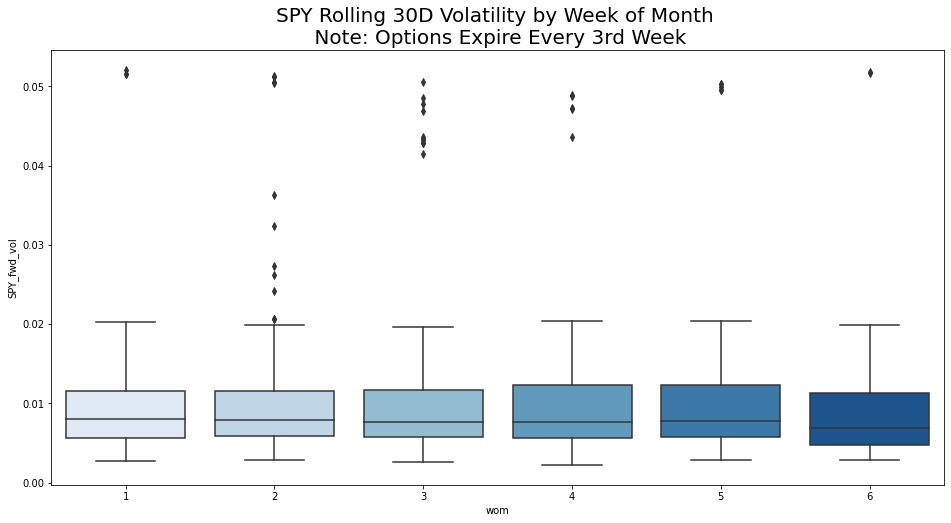

In [ ]:
plt.title('SPY Rolling 30D Volatility by Week of Month \n Note: Options Expire Every 3rd Week', fontsize=20)
sns.boxplot(data=df, x='wom', y='SPY_fwd_vol', palette='Blues')
plt.show()

In [ ]:
anova_df = pd.DataFrame(columns = ['stat', '+/-', 'effect_size', 'p-value', 'skewness', 'kurtosis'])

for feat in df[['mnth', 'wom']]:
  anova_list = df.groupby(feat)['SPY_fwd_vol'].apply(list)
  f, p = stats.f_oneway(*anova_list)

  anova_df.loc[feat] = ['F', '', abs(round(f,3)), round(p,6), '', '']

anova_df.head()

,stat,+/-,effect_size,p-value,skewness,kurtosis
mnth,F,,12.989,0.000000,,
wom,F,,0.619,0.685115,,


## **Pearson Correlation $(r)$ and p-value**

In [ ]:
pearson_df = pd.DataFrame(columns = ['stat', '+/-', 'effect_size', 'p-value', 'skewness', 'kurtosis'])

for col in df.drop('SPY_fwd_vol', axis=1):
  r,p = stats.pearsonr(df[col], df['SPY_fwd_vol'])
  s, k = stats.skew(df[col]), stats.kurtosis(df[col])
  pearson_df.loc[col] = ['r', np.sign(r), abs(round(r,3)), round(p,6), round(s,3), round(k,3)]

pearson_df.sort_values(by=['effect_size', 'p-value'], ascending=False)

,stat,+/-,effect_size,p-value,skewness,kurtosis
VLUE,r,1.0,0.931,0.000000,4.236,25.721
MDY,r,1.0,0.922,0.000000,4.459,28.119
DVY,r,1.0,0.883,0.000000,4.618,29.122
EFA,r,1.0,0.873,0.000000,3.729,20.973
IJR,r,1.0,0.859,0.000000,3.957,22.522
EEM,r,1.0,0.854,0.000000,4.091,25.057
VGLT,r,1.0,0.759,0.000000,3.705,21.616
PA=F,r,1.0,0.738,0.000000,2.894,13.102
CL=F,r,1.0,0.735,0.000000,3.173,15.804
PL=F,r,1.0,0.608,0.000000,1.976,7.516


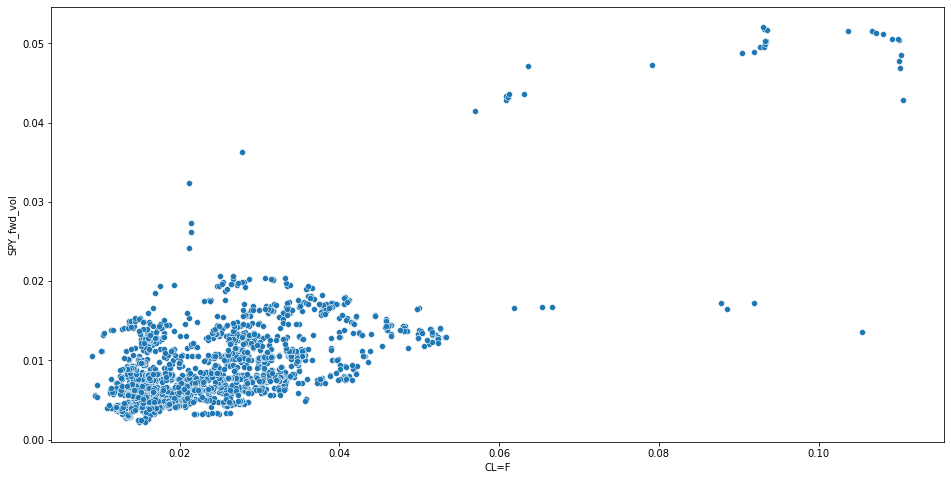

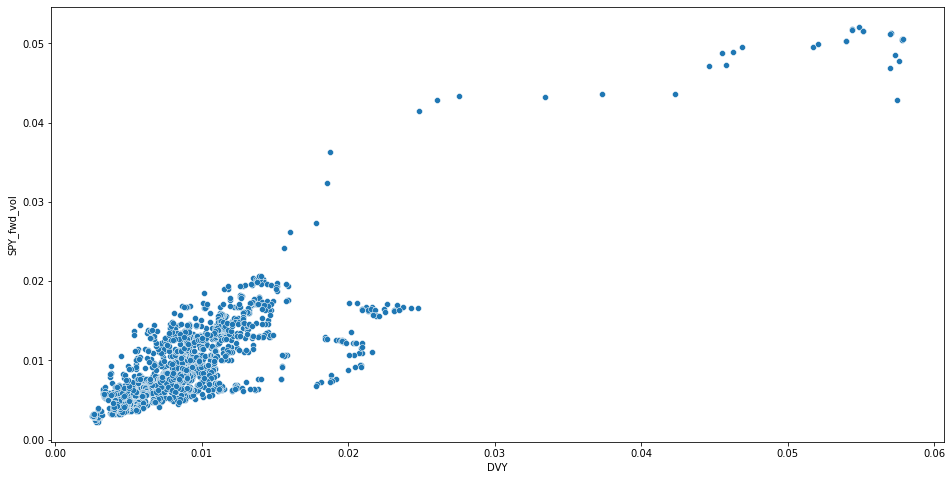

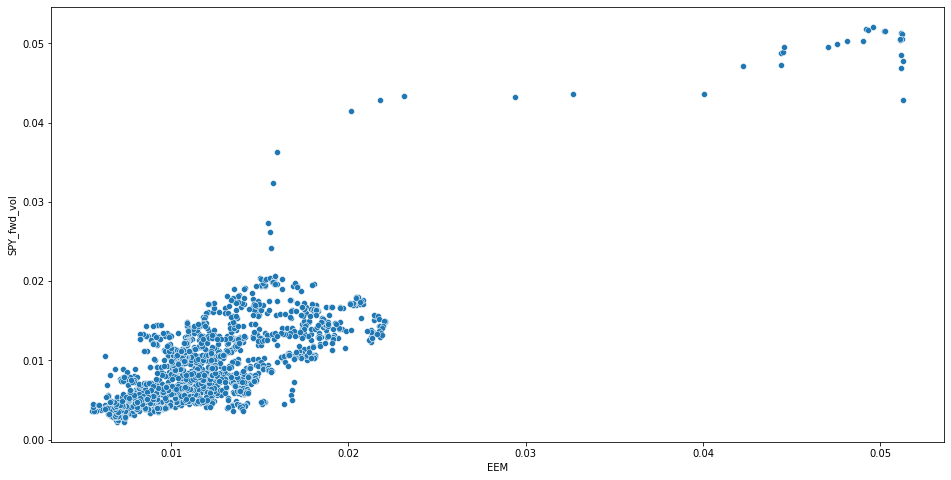

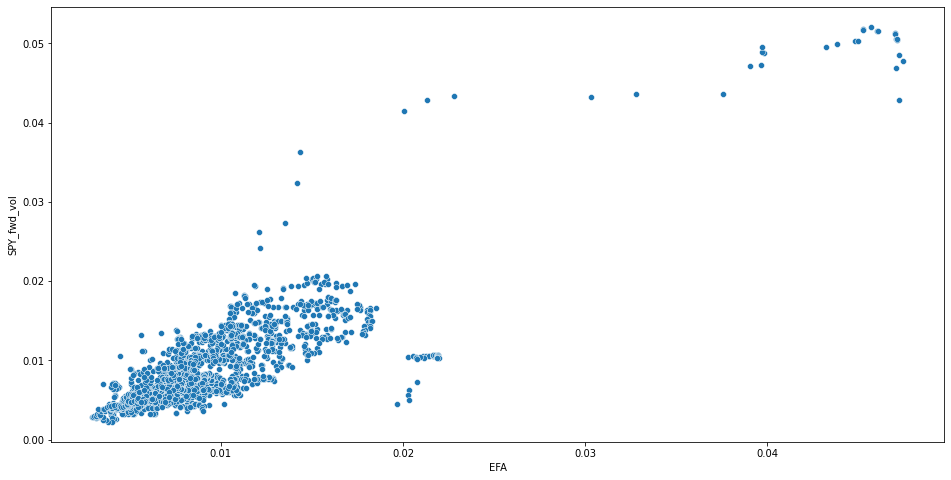

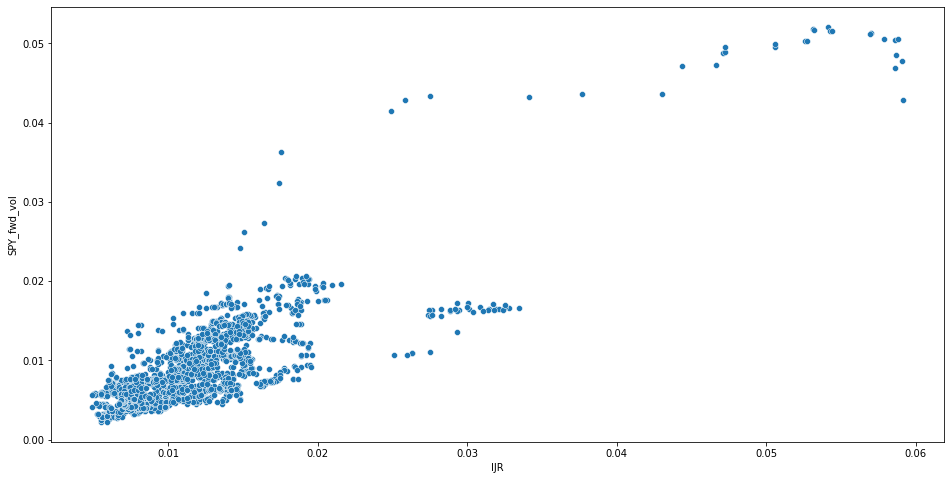

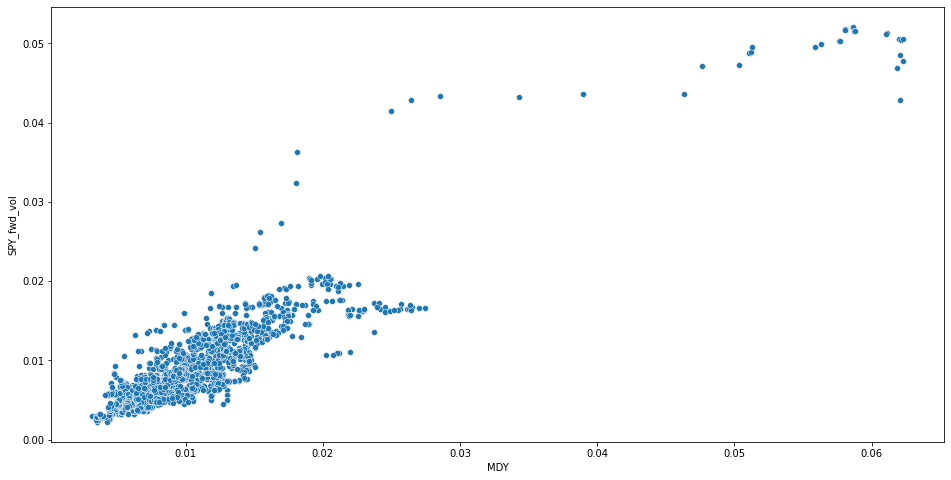

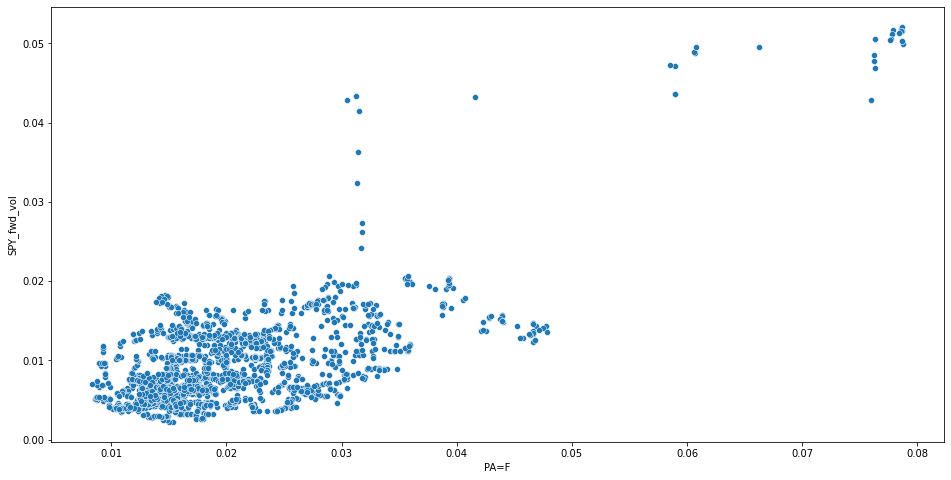

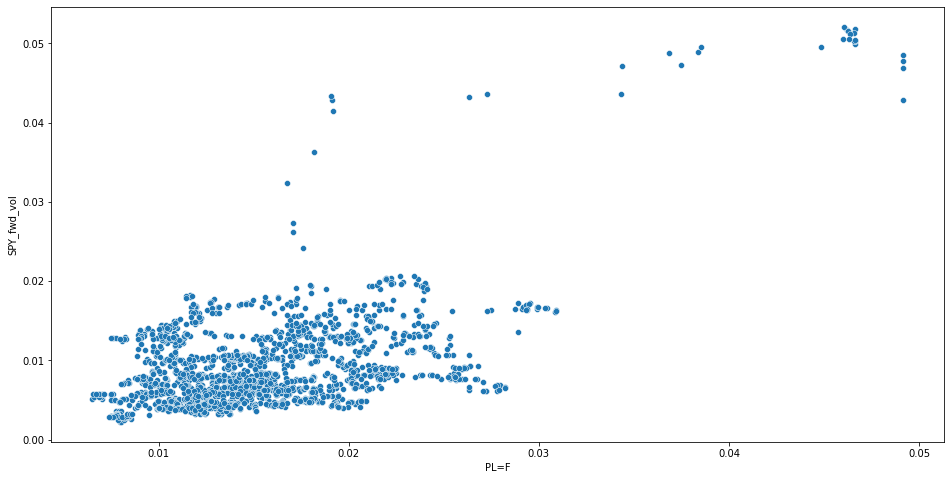

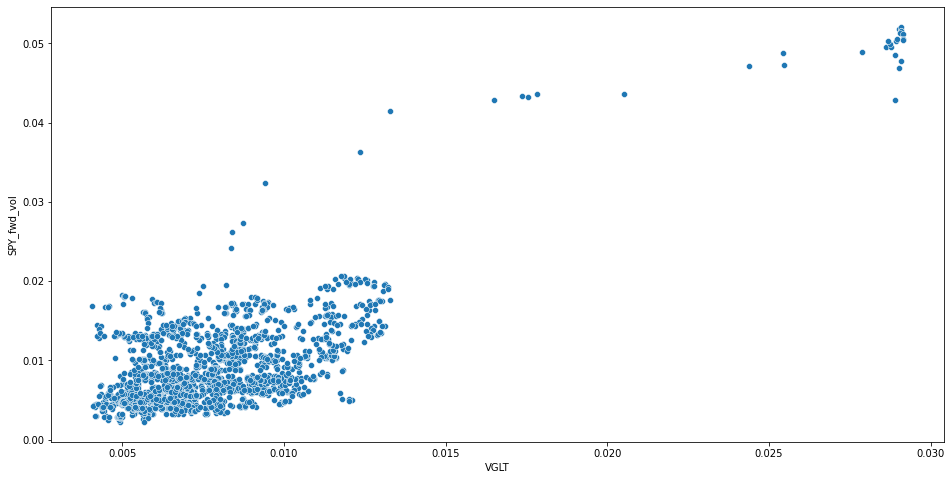

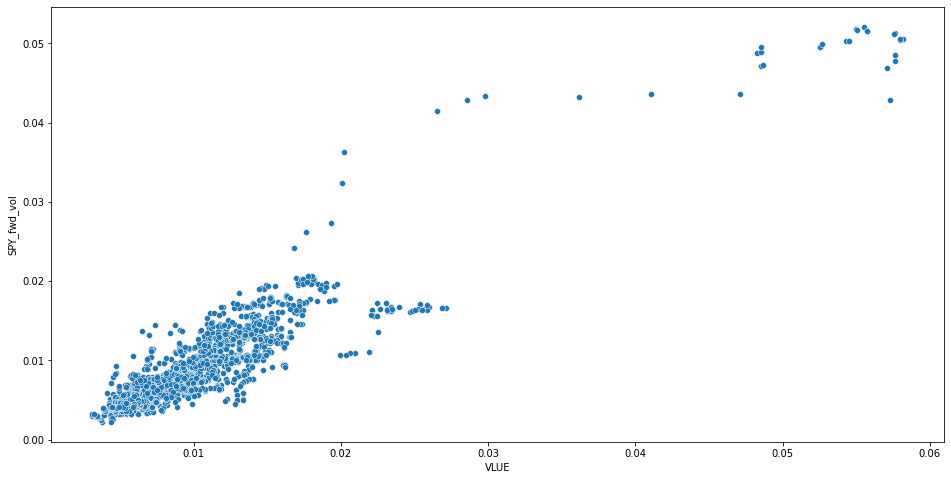

In [ ]:
strong_r = list(pearson_df[pearson_df.effect_size > 0.6].index)

for col in strong_r:
  sns.scatterplot(x=df[col], y=df.SPY_fwd_vol)
  plt.show()

## **Statistical Feature Selection**

In [ ]:
features_table = pd.concat([pearson_df[pearson_df.effect_size > 0.6], anova_df[anova_df['p-value'] < 0.05]])
features_table.sort_values(by=['effect_size', 'p-value'], ascending=[False, True])

,stat,+/-,effect_size,p-value,skewness,kurtosis
mnth,F,,12.989,0.0,,
VLUE,r,1.0,0.931,0.0,4.236,25.721
MDY,r,1.0,0.922,0.0,4.459,28.119
DVY,r,1.0,0.883,0.0,4.618,29.122
EFA,r,1.0,0.873,0.0,3.729,20.973
IJR,r,1.0,0.859,0.0,3.957,22.522
EEM,r,1.0,0.854,0.0,4.091,25.057
VGLT,r,1.0,0.759,0.0,3.705,21.616
PA=F,r,1.0,0.738,0.0,2.894,13.102
CL=F,r,1.0,0.735,0.0,3.173,15.804


In [ ]:
# Very skewed, so assumptions do not hold

# **OLS**
* Sklearn shuffles the data so statsmodels.api may be better for timeseries data

In [ ]:
import statsmodels.api as sm

## Defining and splitting data set

In [ ]:
features = df[features_table.index]

y = df[['SPY_fwd_vol']]
X = features.assign(const=1)

In [ ]:
# manually split data set so it doesnt shuffle like Sklearn
tsize=  0.75

train_size = int(tsize * X.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

print(X_train.shape, y_train.shape, y_test.shape)

## Fitting linear model

In [ ]:
results = sm.OLS(y_train, X_train).fit()

print(results.summary())

## Prediction

In [ ]:
train_prediction = results.predict(X_train)
test_prediction = results.predict(X_test)

In [ ]:
sns.scatterplot(x=train_prediction, y=y_train.SPY_fwd_vol, label='train')
sns.scatterplot(x=test_prediction, y=y_test.SPY_fwd_vol, label='test')

plt.show()

In [ ]:
plt.title('Residuals')
sns.histplot(test_prediction - y_test.SPY_fwd_vol, bins=25);

print(np.std(test_prediction - y_test.SPY_fwd_vol))

## Removing features
* remove the variables that matter the least
* low Coefficient, low t-stat, and high p-value

In [ ]:
# Pull specific results into a dataframe
# t-test is really important for MLR so we can sort by t-stat
features_table = pd.DataFrame({'coef': results.params, 't': abs(results.tvalues), 'p': results.pvalues})
features_table.sort_values(by=['t', 'p'], ascending=[False,True])

In [ ]:
features_sel = features_table[features_table.p < 0.05] # Drop features over 0.05 p-value
features_sel = features_sel.drop('const')
features_sel

# Final OLS model

In [ ]:
features = df[features_sel.index]

X = features.assign(const=1)
y = df[['SPY_fwd_vol']]

In [ ]:
# manually split data set so it doesnt shuffle like Sklearn
tsize=  0.75

train_size = int(tsize * X.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print(X_train.shape, y_train.shape, y_test.shape)

In [ ]:
results = sm.OLS(y_train, X_train).fit()

print(results.summary())

In [ ]:
train_prediction = results.predict(X_train)
test_prediction = results.predict(X_test)

sns.scatterplot(x=train_prediction, y=y_train.SPY_fwd_vol, label='train')
sns.scatterplot(x=test_prediction, y=y_test.SPY_fwd_vol, label='test')

plt.show()

In [ ]:
test_prediction

In [ ]:
plt.title('Predicted vs Actual Forward 5D SPY Volatility', fontsize=20)


sns.lineplot(x=test_prediction.index, y=test_prediction, label='Predict Forward Volatility')
sns.lineplot(x=y_test.index, y=y_test.SPY_fwd_vol, linewidth=.5, label='Actual Forward Volatility')
plt.show()

In [ ]:
plt.title('Residuals', fontsize=20)
sns.histplot(test_prediction - y_test.SPY_fwd_vol, bins=25);

print(np.std(test_prediction - y_test.SPY_fwd_vol))
